In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the Colombia.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the Colombia.


In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
print(result)

content="Orcas, also known as killer whales, can occasionally be spotted off the Pacific coast of Colombia. Though sightings are not as frequent as in some other parts of the world, there are still opportunities to see these magnificent creatures.\n\nOne of the best places to potentially see orcas in Colombia is the Pacific coastal region, particularly near the areas of Bahía Solano and Nuquí. These areas are known for their rich marine biodiversity and are popular for various marine activities, including whale watching. While humpback whales are more commonly observed here, orcas do pass through these waters, usually as transient pods.\n\nIf you're planning to visit, the best time of year for whale watching in general in this region is between July and October, primarily for humpback whales. However, sightings of orcas can be more unpredictable, so it's beneficial to connect with local tour operators or guides who might have up-to-date information on recent sightings.\n\nKeep in mind 

In [7]:
result.response_metadata

{'token_usage': {'completion_tokens': 216,
  'prompt_tokens': 67,
  'total_tokens': 283,
  'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_a20a4ee344',
 'finish_reason': 'stop',
 'logprobs': None}

In [10]:
simple_call = llm.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
simple_call

AIMessage(content='2 multiplied by 3 is 6.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 17, 'total_tokens': 26, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e5e4913e83', 'finish_reason': 'stop', 'logprobs': None}, id='run-50169b41-b5d0-4656-b0b9-62b742ca63ec-0', usage_metadata={'input_tokens': 17, 'output_tokens': 9, 'total_tokens': 26, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [17]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b."""
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [29]:
messages = []
ai_msg = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
print(ai_msg.tool_calls)
messages.append(ai_msg)

[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_0Me6IORxUWkeXTK2YktB2Hcj', 'type': 'tool_call'}]


In [30]:
for tool_call in ai_msg.tool_calls:
    selected_tool = {"multiply": multiply}[tool_call["name"].lower()]
    tool_msg = selected_tool.invoke(tool_call)
    messages.append(tool_msg)

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_0Me6IORxUWkeXTK2YktB2Hcj)
 Call ID: call_0Me6IORxUWkeXTK2YktB2Hcj
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [31]:
llm_with_tools.invoke(messages)

AIMessage(content='The result of multiplying 2 by 3 is 6.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 68, 'total_tokens': 82, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6b68a8204b', 'finish_reason': 'stop', 'logprobs': None}, id='run-bf6ca19e-2bb6-41f0-a335-ea292ee3bdfd-0', usage_metadata={'input_tokens': 68, 'output_tokens': 14, 'total_tokens': 82, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [32]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [35]:
from langgraph.graph.message import add_messages

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
messages = add_messages(initial_messages , new_message)

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

Hello! How can I assist you?
================================ Human Message =================================
Name: Lance

I'm looking for information on marine biology.
================================== Ai Message ==================================
Name: Model

Sure, I can help with that. What specifically are you interested in?


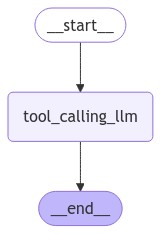

In [36]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [38]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_EgD2tjfWhI5i0tU6zLptGOav)
 Call ID: call_EgD2tjfWhI5i0tU6zLptGOav
  Args:
    a: 2
    b: 3
